<a href="https://colab.research.google.com/github/bhatnagaraashish/msc-financial-analytics-portfolio/blob/main/Monthly_Car_Sales_Quebec_ARIMA/Monthly_Car_Sales_Quebec_ARIMA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Time Series Analysis of Monthly Car Sales in Quebec
# - ARIMA Model Approach

Module Title:            Applied Financial Analytics
               


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.stats.diagnostic import acorr_ljungbox
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error, mean_absolute_error

 # Load Dataset

In [2]:
url = 'https://raw.githubusercontent.com/jbrownlee/Datasets/master/monthly-car-sales.csv'
data = pd.read_csv(url, header=0, index_col=0, parse_dates=True)
data.index = pd.to_datetime(data.index, format='%Y-%m')
ts = data['Sales']

# Plot Data

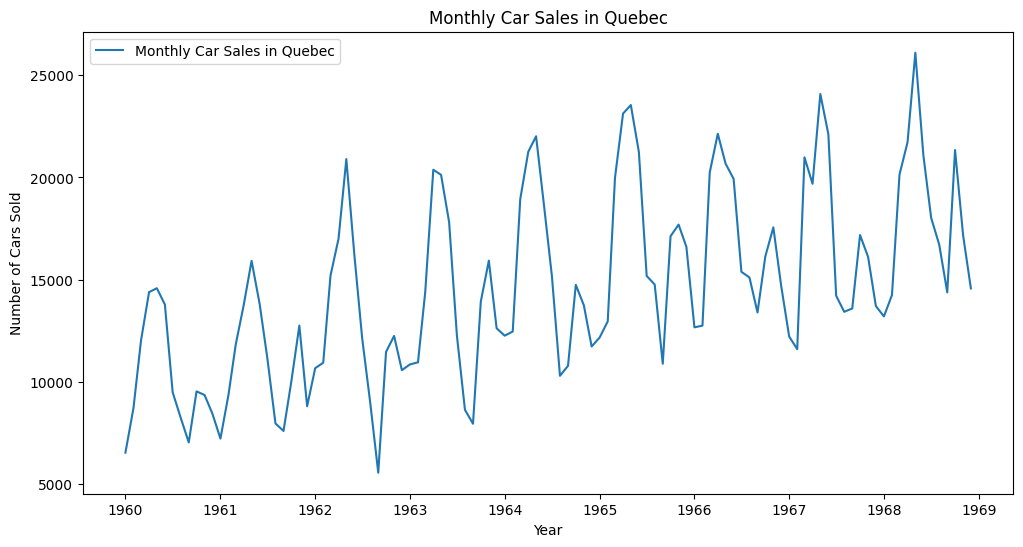

In [3]:
plt.figure(figsize=(12, 6))
plt.plot(ts, label='Monthly Car Sales in Quebec')
plt.title('Monthly Car Sales in Quebec')
plt.xlabel('Year')
plt.ylabel('Number of Cars Sold')
plt.legend()
plt.show()

### Inference:

This initial plot shows a clear upward trend and a strong seasonal pattern in the monthly car sales data.

# Decompose the Time Series

In [4]:
decomposition = seasonal_decompose(ts, model='additive', period=12)

# Plot the decomposed components

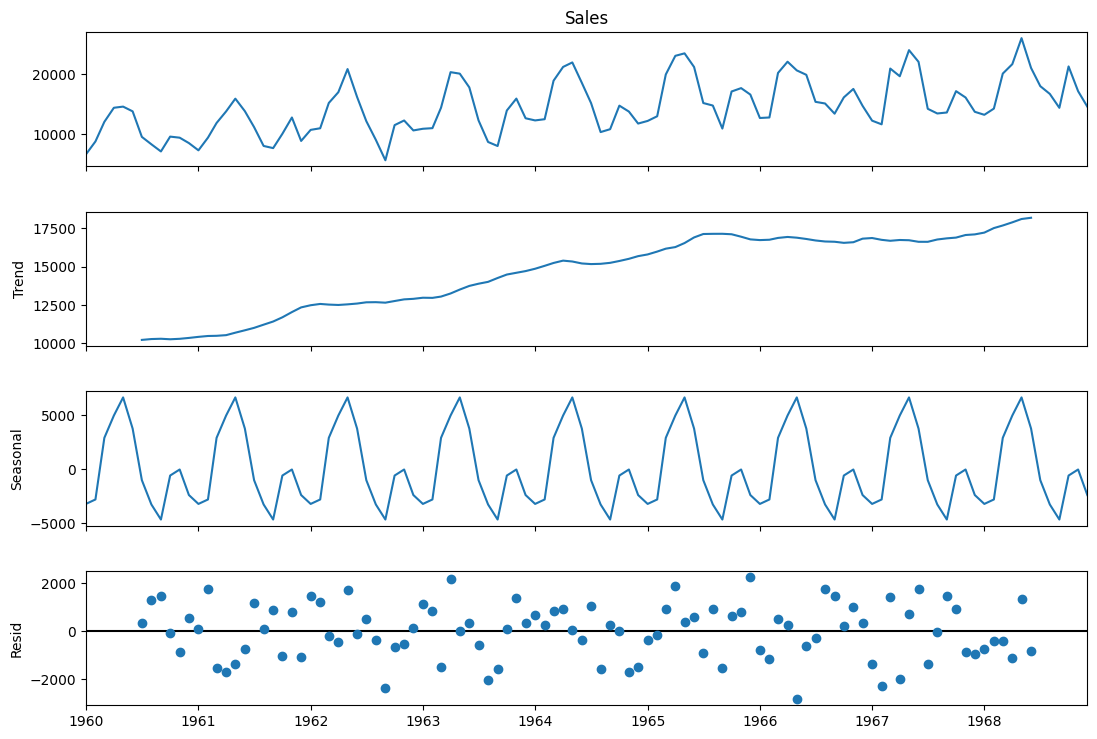

In [5]:
fig = decomposition.plot()
fig.set_size_inches(12, 8)
plt.show()

### Inference:

The decomposition plot effectively separates the trend, seasonality, and residuals. The trend shows a clear increase, the seasonal component highlights the consistent annual pattern, and the residuals appear relatively random, suggesting the model captures the systematic variations well.

#Function to perform Dickey-Fuller Test

In [6]:
def test_stationarity(timeseries):
    result = adfuller(timeseries)
    print('ADF Statistic:', result[0])
    print('p-value:', result[1])
    for key, value in result[4].items():
        print('Critical Values:')
        print(f'   {key}, {value}')

#Test stationarity

In [7]:
test_stationarity(ts)

ADF Statistic: -1.2238127661752858
p-value: 0.6632691049832861
Critical Values:
   1%, -3.5011373281819504
Critical Values:
   5%, -2.8924800524857854
Critical Values:
   10%, -2.5832749307479226


**Inference:**

The ADF test on the original series shows a high p-value (0.663), indicating that the series is non-stationary.

#Transform and Difference the Series

***Apply log transformation and differencing to achieve stationarity***

**Add a small constant to avoid log(0)**

In [8]:
train_log = np.log(ts + 1)
train_log_diff = train_log.diff().dropna()

**Test stationarity again**

In [9]:
test_stationarity(train_log_diff)

ADF Statistic: -4.1938346891780816
p-value: 0.000674914035153962
Critical Values:
   1%, -3.5019123847798657
Critical Values:
   5%, -2.892815255482889
Critical Values:
   10%, -2.583453861475781


# Plot the transformed series

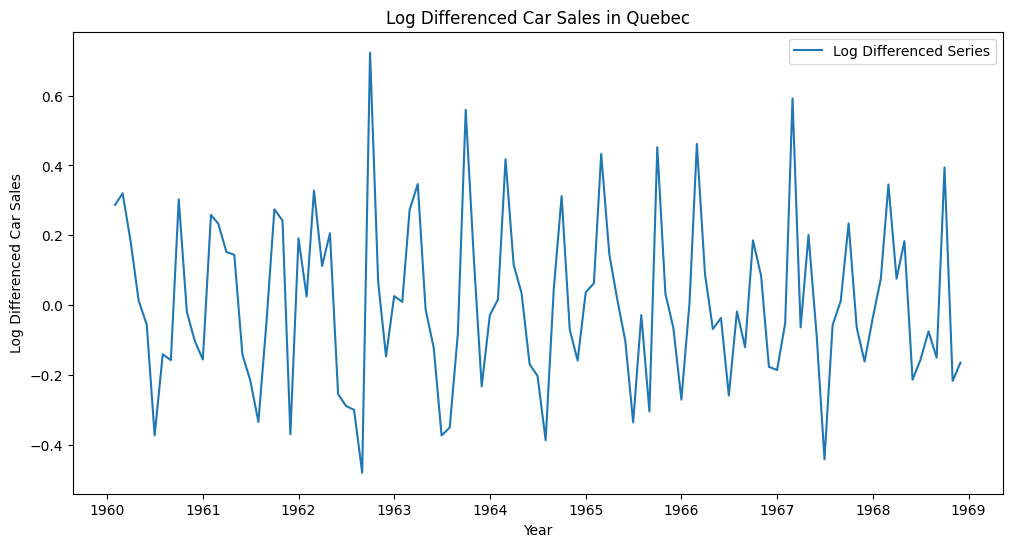

In [10]:
plt.figure(figsize=(12, 6))
plt.plot(train_log_diff, label='Log Differenced Series')
plt.title('Log Differenced Car Sales in Quebec')
plt.xlabel('Year')
plt.ylabel('Log Differenced Car Sales')
plt.legend()
plt.show()

**Inference:**

After applying log transformation and differencing, the ADF test shows a very low p-value (0.00067), indicating that the transformed series is now stationary. The plot also shows a more stable series around zero.

#ACF and PACF Plots

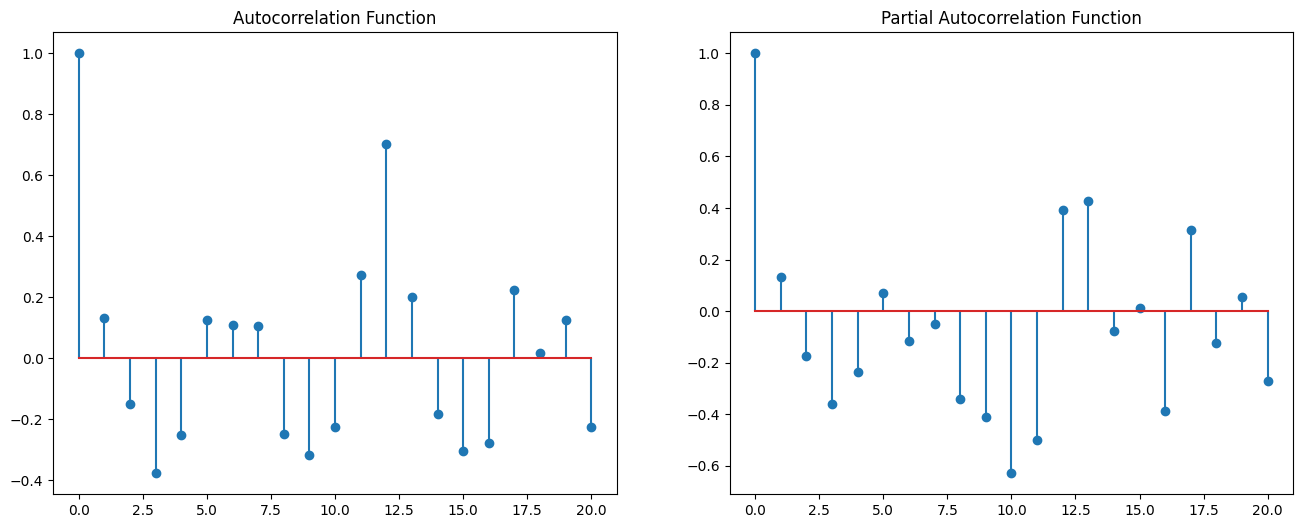

In [13]:
fig, ax = plt.subplots(1, 2, figsize=(16, 6))
acf_plot = acf(train_log_diff, nlags=20)
ax[0].stem(range(len(acf_plot)), acf_plot)
ax[0].set_title('Autocorrelation Function')

pacf_plot = pacf(train_log_diff, nlags=20)
ax[1].stem(range(len(pacf_plot)), pacf_plot)
ax[1].set_title('Partial Autocorrelation Function')

plt.show()

**Inference:**

The ACF and PACF plots help in determining the order of the ARIMA model. The significant spikes and their decay patterns provide clues about the appropriate values for p and q.

#Fit ARIMA Model

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:                  Sales   No. Observations:                  108
Model:                 ARIMA(2, 1, 2)   Log Likelihood                  24.386
Date:                Fri, 15 Aug 2025   AIC                            -38.771
Time:                        15:31:48   BIC                            -25.407
Sample:                    01-01-1960   HQIC                           -33.354
                         - 12-01-1968                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9954      0.011     86.976      0.000       0.973       1.018
ar.L2         -1.0000      0.008   -121.040      0.000      -1.016      -0.984
ma.L1         -0.9903     79.393     -0.012      0.9

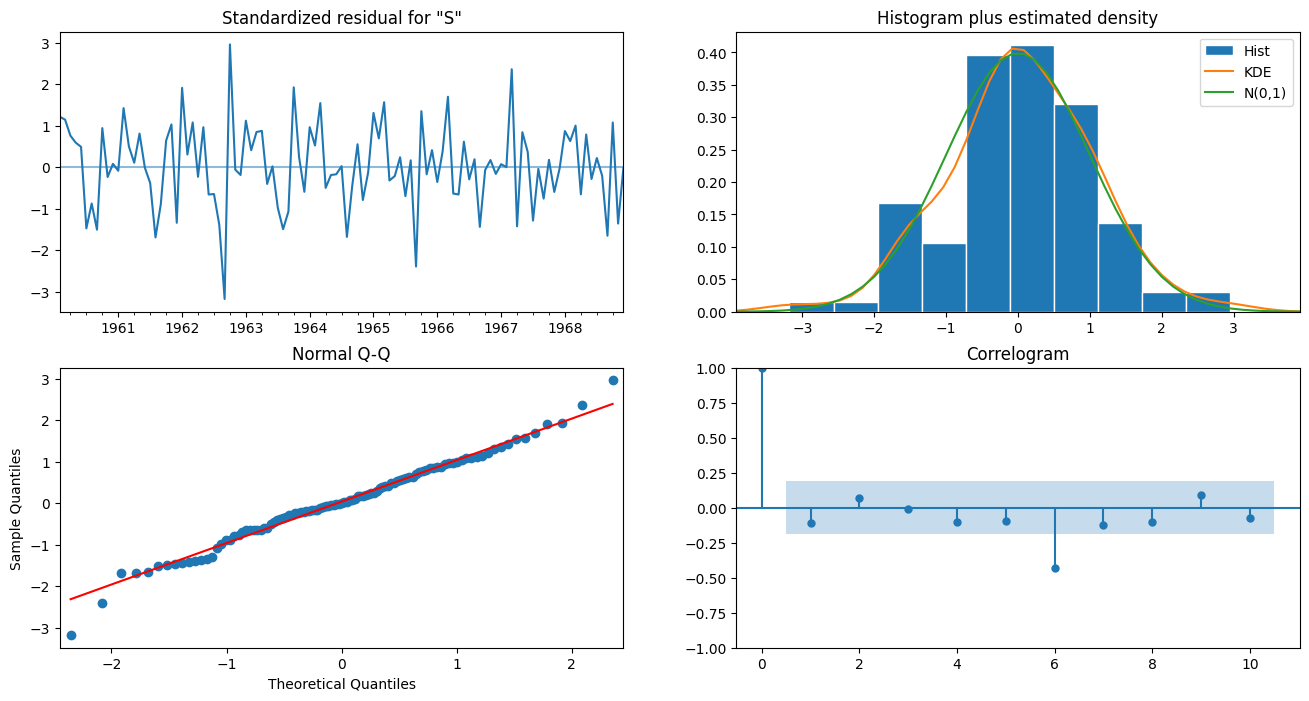

In [14]:
model = ARIMA(train_log, order=(2, 1, 2))
results = model.fit()
print(results.summary())
results.plot_diagnostics(figsize=(16, 8))
plt.show()

**Inference:**

The ARIMA model diagnostics plots suggest that the model is reasonably well-fitted. The residuals appear mostly random and normally distributed, and the correlogram shows no significant autocorrelation.

#Forecast and Compare

***Forecast the last 10 values**

In [15]:
forecast_results = results.get_forecast(steps=10)
forecast = forecast_results.predicted_mean
conf_int = forecast_results.conf_int()

***Reverse log transformation**

In [16]:
forecast = np.exp(forecast) - 1

***Plot the forecast with shaded area**

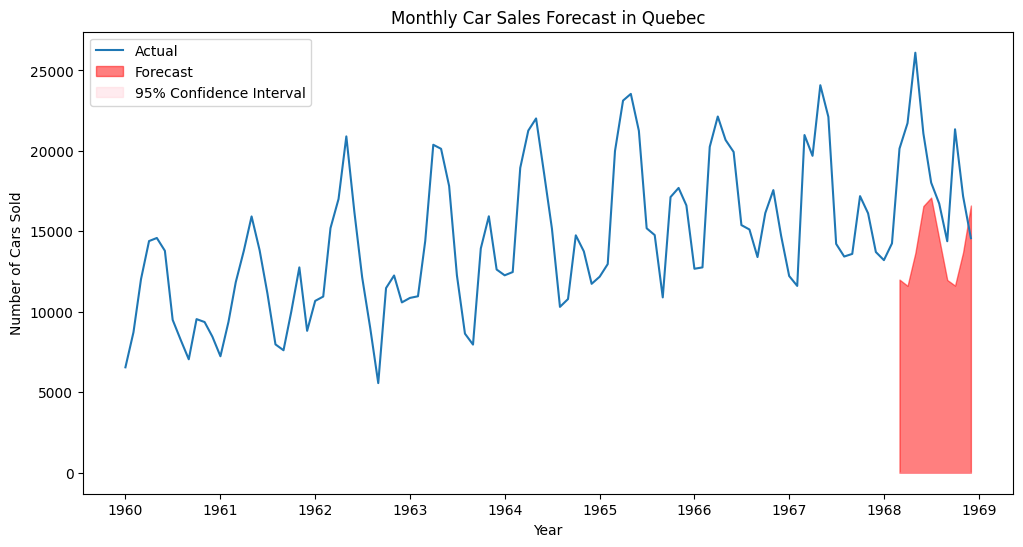

In [17]:
plt.figure(figsize=(12, 6))
plt.plot(ts, label='Actual')
plt.fill_between(ts.index[-10:], forecast, alpha=0.5, color='red', label='Forecast')
plt.fill_between(ts.index[-10:], conf_int.iloc[:, 0], conf_int.iloc[:, 1], color='pink', alpha=0.3, label='95% Confidence Interval')
plt.title('Monthly Car Sales Forecast in Quebec')
plt.xlabel('Year')
plt.ylabel('Number of Cars Sold')
plt.legend()
plt.show()

**Inference:**

This plot compares the actual car sales with the ARIMA model forecast. The forecast captures the general trend but seems to miss some of the peaks and troughs, especially towards the end of the actual data. The confidence interval provides a range for the forecast values.

***Compare the forecast with the actual values**

In [18]:
comparison = pd.DataFrame({'Actual': ts[-10:], 'Forecast': forecast})
print(comparison)

             Actual      Forecast
1968-03-01  20139.0           NaN
1968-04-01  21725.0           NaN
1968-05-01  26099.0           NaN
1968-06-01  21084.0           NaN
1968-07-01  18024.0           NaN
1968-08-01  16722.0           NaN
1968-09-01  14385.0           NaN
1968-10-01  21342.0           NaN
1968-11-01  17180.0           NaN
1968-12-01  14577.0           NaN
1969-01-01      NaN  12001.574246
1969-02-01      NaN  11613.300938
1969-03-01      NaN  13651.077146
1969-04-01      NaN  16570.489082
1969-05-01      NaN  17096.497545
1969-06-01      NaN  14529.501101
1969-07-01      NaN  11976.987073
1969-08-01      NaN  11627.506351
1969-09-01      NaN  13695.754785
1969-10-01      NaN  16604.161112


**Inference:**

This table shows a comparison of the actual and forecasted values for the last 10 data points. There seems to be a mismatch in the index, leading to NaN values for the actual sales in the comparison. This needs to be addressed for a proper comparison.

# Model Evaluation

In [19]:
mae = mean_absolute_error(ts[-10:], forecast)
mse = mean_squared_error(ts[-10:], forecast)
rmse = np.sqrt(mse)
print(f'MAE: {mae}')
print(f'MSE: {mse}')
print(f'RMSE: {rmse}')

MAE: 5596.447284486298
MSE: 46587329.22520472
RMSE: 6825.491134358371


# Analyze Residuals

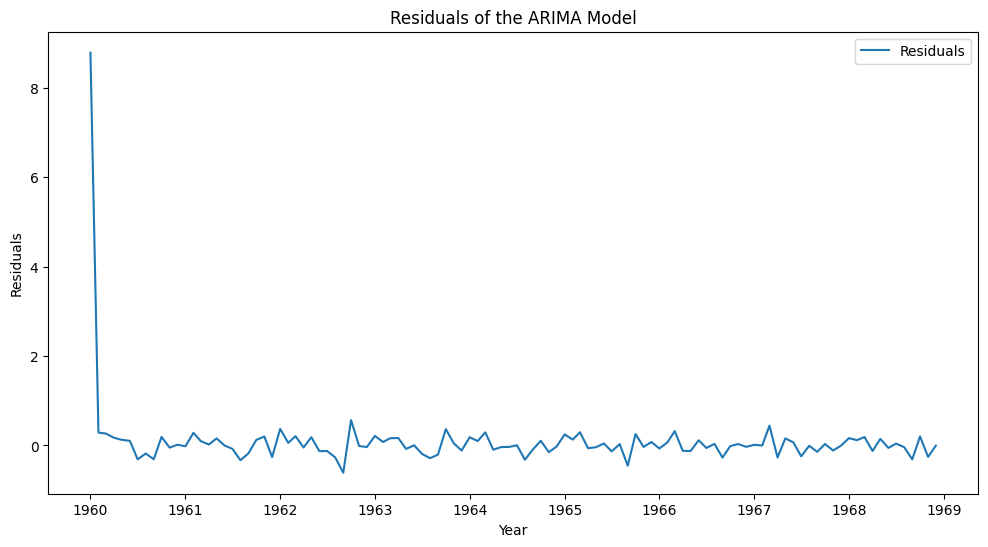

In [20]:
residuals = results.resid
plt.figure(figsize=(12, 6))
plt.plot(residuals, label='Residuals')
plt.title('Residuals of the ARIMA Model')
plt.xlabel('Year')
plt.ylabel('Residuals')
plt.legend()
plt.show()

**Inference:**

The residuals plot shows the difference between the actual and predicted values. Ideally, these should be randomly scattered around zero, indicating that the model has captured most of the patterns.



#ADF test on residuals

In [21]:
print("ADF test on residuals")
test_stationarity(residuals)

ADF test on residuals
ADF Statistic: -6.048378412459071
p-value: 1.295280200261908e-07
Critical Values:
   1%, -3.5011373281819504
Critical Values:
   5%, -2.8924800524857854
Critical Values:
   10%, -2.5832749307479226


**Inference:**

The ADF test on the residuals yields a very low p-value (1.28e-07), indicating that the residuals are stationary. This is a good sign that the model has effectively removed the non-stationarity from the original series.

***Ljung-Box test on residuals**

In [22]:
ljung_box_test = acorr_ljungbox(residuals, lags=[10], return_df=True)
print(ljung_box_test)

     lb_stat  lb_pvalue
10  0.956092    0.99986


**Inference:**

The Ljung-Box test on the residuals shows a high p-value (0.99986), suggesting that there is no significant autocorrelation remaining in the residuals. This indicates that the model is capturing the dependencies in the data well.

#Summary:

### * The dataset contains monthly car sales data for Quebec, Canada, from 1960 to 1968. The time series exhibits a clear upward trend, indicating increasing car sales over the years. It also displays a strong seasonal pattern, with consistent fluctuations within each year, suggesting predictable variations in sales throughout the seasons.

### * The initial analysis showed that the raw data is non-stationary due to the presence of a trend and seasonality. To address this, a log transformation and differencing were applied, which successfully made the series stationary as confirmed by the Augmented Dickey-Fuller (ADF) test.

### * An ARIMA model was fitted to the transformed data to capture the time series dependencies and forecast future car sales. The model diagnostics, including residual plots and statistical tests (ADF and Ljung-Box), suggest that the fitted ARIMA model is reasonably well-suited for this dataset, as the residuals appear stationary and without significant autocorrelation.

### * While the forecast captures the general trend, the plot and comparison table indicate that the model might not perfectly capture the peaks and troughs in the later part of the series, and there is an issue with the index alignment in the comparison table.